### Clustering Analysis
En esta sección se analizarán los clusters obtenidos del notebook 3.0

#### Selección del dataframe con los mejores clusters
Se seleccionará el dataframe con los mejores clusters de acuerdo con las métricas de evaluación de calidad que utilizamos en el notebook anterior.

In [143]:
# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score

In [144]:
# Loading cleaned dataset
dataset_path = "../data/processed/cleaned_dataset.csv"
df = pd.read_csv(dataset_path)
df = df.drop(columns=["ID", "dias_primera_compra", "n_clicks", "info_perfil"])

In [145]:
# Util functions
def scale_minmax(df, column):
    scaler = MinMaxScaler()
    df[column] = scaler.fit_transform(df[[column]])
def visualize_clusters(df_scaled, df_objective, column):
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(df_scaled)
    plt.figure(figsize=(6, 4))
    plt.scatter(principal_components[:, 0], principal_components[:, 1], c=df_objective[column], cmap='viridis', s=1)
    plt.title('Cluster Visualization (PCA)')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.colorbar(label='Cluster')
    plt.show
def evaluate_clusters(df_scaled, df_objective, column):
    print(f"Silhouette = {silhouette_score(df_scaled, df_objective[column]):.4f}\n"
          f"Davies-Bouldin = {davies_bouldin_score(df_scaled, df_objective[column]):.4f}")
    visualize_clusters(df_scaled, df_objective, column)
def plot_correlation_heatmap(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(6, 4))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title("Heatmap")
    plt.show()

In [146]:
# Scaling variables
df_scaled = df.copy()
for i in list(df.columns):
    scale_minmax(df_scaled, i)

In [147]:
# DBSCAN
df_dbscan = df.copy()
dbscan = DBSCAN(eps = 0.04, min_samples = 50)
df_dbscan['cluster'] = dbscan.fit_predict(df_scaled)
scaled_db = df_scaled[df_dbscan["cluster"] != -1]
df_dbscan = df_dbscan[df_dbscan["cluster"] != -1]

```python
# K-Means
df_kmeans = df.copy()
kmeans = KMeans(n_clusters=3).fit(df_scaled.values)
df_kmeans["cluster"] = kmeans.labels_

# Gaussian Mixture
df_gaussi = df.copy()
n_clusters_ = 3  
gaussian = GaussianMixture(
    n_components=n_clusters_, 
    covariance_type='full',  
    init_params='kmeans',    
    max_iter=100, 
    tol=1e-3, 
    random_state=42         
)
df_gaussi["cluster"] = gaussian.fit_predict(df_scaled)

# Agglomerative
df_agglom = df.copy()
sample_size = 26000
random_indexes = np.random.choice(df_scaled.shape[0], sample_size, replace=False)
scaled_ag = df_scaled.iloc[random_indexes]
df_agglom = df_agglom.iloc[random_indexes]
agglomerative = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')
df_agglom["cluster"] = agglomerative.fit_predict(scaled_ag)
```

##### Evaluating clusters

Con el siguiente código:
```python
print("Evaluation of K-Means")
evaluate_clusters(df_scaled, df_kmeans, "cluster")
print("\nEvaluation of DBSCAN")
evaluate_clusters(scaled_db, df_dbscan, "cluster")
print("\nEvaluation of Gaussian Mixture")
evaluate_clusters(df_scaled, df_gaussi, "cluster")
print("\nEvaluation of Agglomerative")
evaluate_clusters(scaled_ag, df_agglom, "cluster")
```
Se obtuvo la siguiente salida:
```python
Evaluation of K-Means
    Silhouette = 0.6382
    Davies-Bouldin = 0.5010

Evaluation of DBSCAN
    Silhouette = 0.6605
    Davies-Bouldin = 0.4660

Evaluation of Gaussian Mixture
    Silhouette = 0.6328
    Davies-Bouldin = 0.5062

Evaluation of Agglomerative
    Silhouette = 0.6346
    Davies-Bouldin = 0.5064
```
Todos estos métodos fueron exhaustivamente probados y para el número de 3 clusters los resultados de las métricas fueron los mejores. Por lo tanto, analizaremos los resultados de los clusters retornados con DBSCAN, el cual fue el que tuvo los mejores scores de las métricas.

#### **Cluster analysis**

El análisis detallado de los clusters tiene como objetivo identificar patrones, diferencias y similitudes entre los segmentos generados, lo que permite comprender mejor los grupos y cómo se relacionan con las variables clave del dataset.

##### **Acciones a Realizar**

1. **Generación de Estadísticas Descriptivas**
   - **Objetivo:** Resumir las características principales de las variables dentro de cada cluster.
   - **Acciones:**
     - Calcular métricas como la **media**, **mediana**, **desviación estándar**, **percentiles**, entre otros, para cada variable en cada cluster.
     - Comparar estas métricas entre clusters para identificar características dominantes o distintivas de cada grupo.
2. **Análisis de Distribuciones Individuales**
   - **Objetivo:** Evaluar cómo se distribuyen las variables dentro de cada cluster.
   - **Acciones:**
     - Crear histogramas o gráficos de densidad para cada variable dentro de cada cluster.
     - Evaluar si las distribuciones son unimodales, bimodales o tienen asimetrías significativas.
     - Identificar valores atípicos dentro de cada cluster y su posible impacto.
3. **Comparaciones Cruzadas entre Clusters**
   - **Objetivo:** Detectar similitudes y diferencias clave entre los clusters.
   - **Acciones:**
     - Generar gráficos de cajas (boxplots) para cada variable, segmentados por cluster.
     - Comparar medianas y rangos intercuartiles entre clusters para identificar variables que contribuyen a la diferenciación.
     - Crear matrices de correlación por cluster si la naturaleza de las variables lo permite.

In [148]:
df = df_dbscan

In [149]:
df.groupby("cluster")["n_visitas"].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,18274.0,66.708602,13.396135,21.0,58.0,67.0,76.0,116.0
1,18331.0,88.772735,24.722026,8.0,72.0,89.0,105.0,170.0
2,15703.0,126.618098,27.242100,50.0,107.0,127.0,146.0,196.0


In [150]:
df.groupby("cluster")["monto_compras"].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,18274.0,3219.142831,631.237138,1232.7,2789.625,3219.1,3652.40,5231.8
1,18331.0,646.164072,179.525850,22.4,525.650,646.4,767.45,1328.5
2,15703.0,1382.168337,302.347517,503.1,1167.300,1382.4,1597.40,2233.5


In [151]:
df.groupby("cluster")["monto_descuentos"].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,18274.0,80.171074,16.114627,6.3,69.3,80.2,91.0,159.8
1,18331.0,145.714418,40.844453,0.6,118.0,145.4,173.6,330.9
2,15703.0,1122.059142,235.676770,478.1,951.7,1120.0,1293.0,1726.7


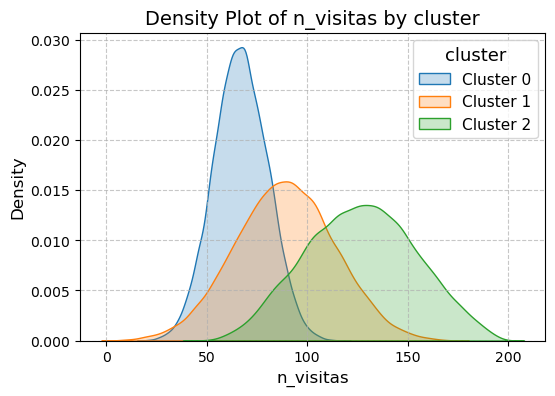

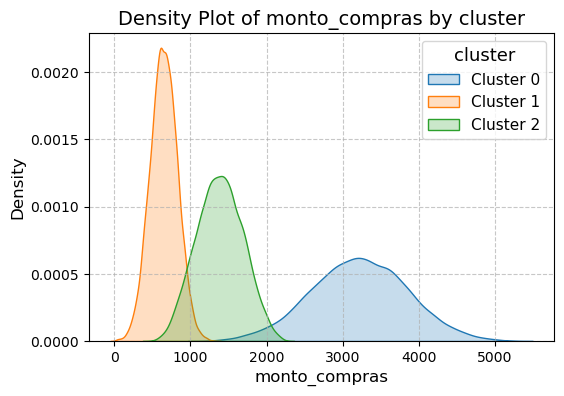

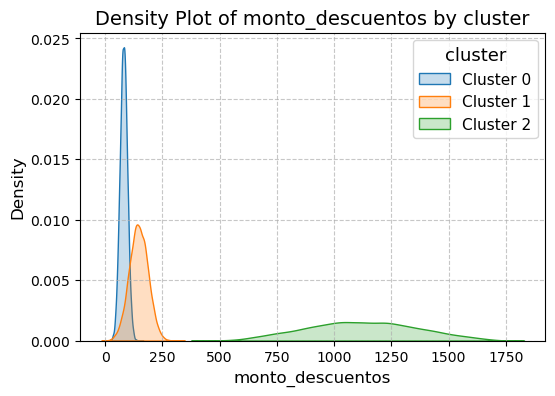

In [152]:
def plot_kde_by_cluster(df, column, cluster_column='cluster'):
    """
    Plot a Kernel Density Estimation (KDE) plot for a specified column grouped by clusters.

    Parameters:
        df (pd.DataFrame): The dataframe containing the data.
        column (str): The column to visualize.
        cluster_column (str): The column representing the clusters (default: 'cluster').

    Returns:
        None: Displays the KDE plot.
    """
    plt.figure(figsize=(6, 4))
    for cluster in df[cluster_column].unique():
        cluster_data = df[df[cluster_column] == cluster]
        sns.kdeplot(cluster_data[column], label=f'Cluster {cluster}', fill=True, common_norm=False)
    plt.title(f'Density Plot of {column} by {cluster_column}', fontsize=14)
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title=cluster_column, title_fontsize='13', fontsize='11')
    plt.show()

plot_kde_by_cluster(df, "n_visitas")
plot_kde_by_cluster(df, "monto_compras")
plot_kde_by_cluster(df, "monto_descuentos")

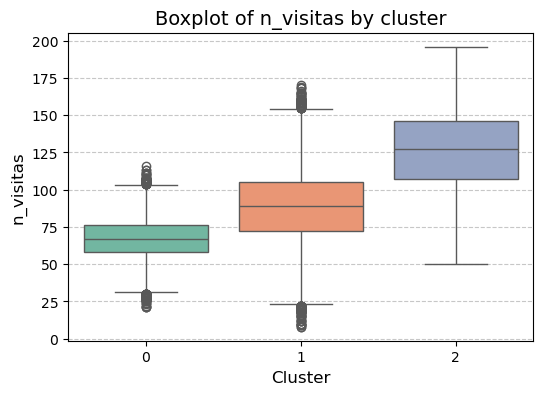

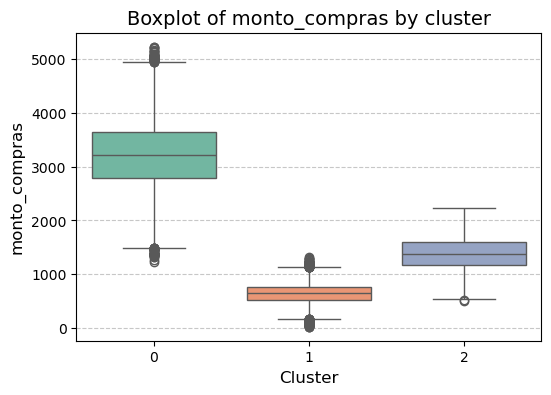

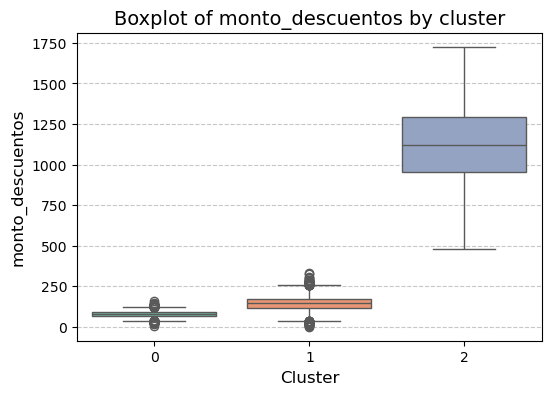

In [153]:
def plot_boxplot_by_cluster(df, column, cluster_column='cluster'):
    """
    Plot a boxplot for a specified column grouped by clusters.

    Parameters:
        df (pd.DataFrame): The dataframe containing the data.
        column (str): The column to visualize.
        cluster_column (str): The column representing the clusters (default: 'cluster').

    Returns:
        None: Displays the boxplot.
    """
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=cluster_column, y=column, data=df, hue=cluster_column, palette='Set2', dodge=False)
    plt.title(f'Boxplot of {column} by {cluster_column}', fontsize=14)
    plt.xlabel('Cluster', fontsize=12)
    plt.ylabel(column, fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend([], [], frameon=False)
    plt.show()

plot_boxplot_by_cluster(df, "n_visitas")
plot_boxplot_by_cluster(df, "monto_compras")
plot_boxplot_by_cluster(df, "monto_descuentos")

Los clientes del cluster 0 son los que más compran pero los que menos interacción y descuentos tienen.

Los clientes del cluster 1 son los que menos compran pero tienen un nivel de interacción moderada y un poco más de descuentos en comparación con los clientes del cluster 0.

Los clientes del cluster 2 son los que compran moderadamente con un nivel alto de interacción y aprovechan demasiados descuentos.

¿A más interacción más descuentos?

#### Cluster Analysis: Metrics Comparison

Below is the analysis comparing the metrics for **n_visitas**, **monto_compras**, and **monto_descuentos** across the three clusters. The aim is to identify dominant or distinctive characteristics of each group.

---

**Cluster 0**  
- **n_visitas**:  
  - Mean: 66.71  
  - Range: 21–116  
  - This cluster exhibits the **lowest mean number of visits** with relatively narrow variability (std = 13.4).  
  - The majority of users have between 58–76 visits.  
- **monto_compras**:  
  - Mean: 3219.14  
  - Range: 1232.7–5231.8  
  - Users in this cluster have the **highest average purchase amount**, suggesting that they are **high-value customers** despite fewer visits.  
- **monto_descuentos**:  
  - Mean: 80.17  
  - Range: 6.3–159.8  
  - Discounts used by this cluster are **minimal**, indicating either low engagement with promotions or targeting of higher-value purchases with fewer discounts.

**Summary**:  
Cluster 0 represents **high-value customers** who visit the site less frequently but make larger purchases with minimal discounts.  

---

**Cluster 1**  
- **n_visitas**:  
  - Mean: 88.77  
  - Range: 8–170  
  - This cluster shows **moderate visit frequency** with a wide range and higher variability (std = 24.7).  
- **monto_compras**:  
  - Mean: 646.16  
  - Range: 22.4–1328.5  
  - This group exhibits the **lowest average purchase amount**, indicating they are likely **low-value customers**.  
- **monto_descuentos**:  
  - Mean: 145.71  
  - Range: 0.6–330.9  
  - Users in this cluster receive **moderate discounts**, possibly as an incentive to encourage purchases.  

**Summary**:  
Cluster 1 comprises **low-value customers** who visit the site moderately but rely more on discounts to make purchases.  

---

**Cluster 2**  
- **n_visitas**:  
  - Mean: 126.62  
  - Range: 50–196  
  - This cluster has the **highest visit frequency** with relatively wide variability (std = 27.2).  
- **monto_compras**:  
  - Mean: 1382.17  
  - Range: 503.1–2233.5  
  - This group has **moderate purchase amounts**, suggesting they are **medium-value customers**.  
- **monto_descuentos**:  
  - Mean: 1122.06  
  - Range: 478.1–1726.7  
  - Discounts in this cluster are the **highest**, which may drive their increased activity and spending.  

**Summary**:  
Cluster 2 represents **medium-value customers** who visit the site most frequently and are highly motivated by discounts.  

---

**Key Observations**
1. **Cluster 0**: High-value customers with fewer visits and minimal reliance on discounts.  
2. **Cluster 1**: Low-value customers with moderate visits and moderate discounts.  
3. **Cluster 2**: Medium-value customers with the highest visits and significant reliance on discounts.  

This segmentation highlights clear behavioral and financial differences, enabling targeted strategies such as personalized marketing or tailored discounting schemes.

---

4. **Análisis Multivariante dentro de los Clusters**
   - **Objetivo:** Explorar relaciones complejas entre variables dentro de cada cluster.
   - **Acciones:**
     - Aplicar PCA (Análisis de Componentes Principales) dentro de clusters específicos para identificar patrones internos más complejos.
     - Realizar análisis bivariados (e.g., gráficos de dispersión) entre pares de variables dentro de los clusters para encontrar relaciones exclusivas de cada segmento.

In [154]:
def filter_by_cluster(df, cluster_value, cluster_column = 'cluster'):
    """Filters the dataframe by a specific cluster value."""
    return df[df[cluster_column] == cluster_value]

def scale_data(df, columns):
    """Scales the selected columns in the dataframe using StandardScaler."""
    scaler = MinMaxScaler()
    df_scaled = df[columns]
    df_scaled = scaler.fit_transform(df_scaled)
    return df_scaled

def apply_pca(data, n_components=2):
    """Applies PCA to the scaled data and returns the reduced dimensions."""
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(data)
    return pca_result, pca

In [155]:
cluster_0_df = filter_by_cluster(df, 0)
cluster_1_df = filter_by_cluster(df, 1)
cluster_2_df = filter_by_cluster(df, 2)

columns_to_scale = ['n_visitas', 'monto_compras', 'monto_descuentos']
scaled_cluster_0 = scale_data(cluster_0_df, columns_to_scale)
scaled_cluster_1 = scale_data(cluster_1_df, columns_to_scale)
scaled_cluster_2 = scale_data(cluster_2_df, columns_to_scale)

pca_cluster_0, pca_model_0 = apply_pca(scaled_cluster_0)
pca_cluster_1, pca_model_1 = apply_pca(scaled_cluster_1)
pca_cluster_2, pca_model_2 = apply_pca(scaled_cluster_2)

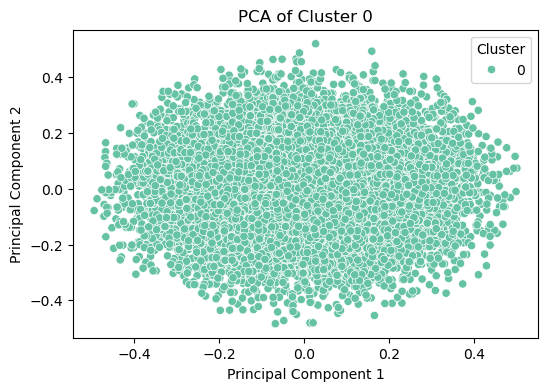

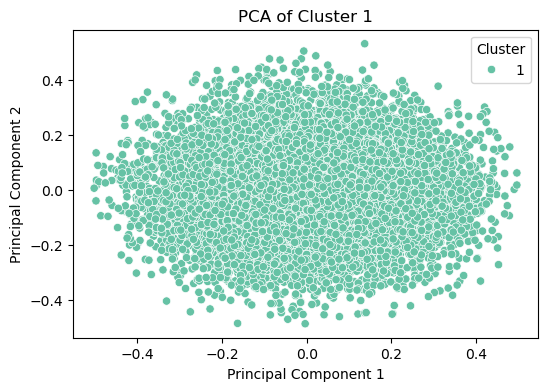

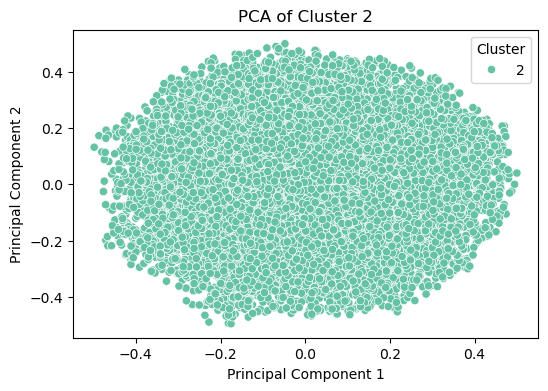

In [156]:
def plot_pca(pca_result, cluster_value):
    """Plots the PCA result for each cluster."""
    pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
    pca_df['Cluster'] = cluster_value
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x='PC1', y='PC2', data=pca_df, hue='Cluster', palette='Set2', legend='full')
    plt.title(f'PCA of Cluster {cluster_value}')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(title='Cluster')
    plt.show()
plot_pca(pca_cluster_0, 0)
plot_pca(pca_cluster_1, 1)
plot_pca(pca_cluster_2, 2)

In [157]:
def pca_loadings(pca_model, columns):
    """Displays the loadings of the PCA components."""
    loadings = pd.DataFrame(pca_model.components_, columns=columns, index=[f'PC{i+1}' for i in range(pca_model.components_.shape[0])])
    return loadings

# Get loadings for each cluster's PCA
loadings_cluster_0 = pca_loadings(pca_model_0, columns_to_scale)
loadings_cluster_1 = pca_loadings(pca_model_1, columns_to_scale)
loadings_cluster_2 = pca_loadings(pca_model_2, columns_to_scale)

print("Loadings for Cluster 0:")
print(loadings_cluster_0)
print("Loadings for Cluster 1:")
print(loadings_cluster_1)
print("Loadings for Cluster 2:")
print(loadings_cluster_2)

Loadings for Cluster 0:
     n_visitas  monto_compras  monto_descuentos
PC1  -0.036640       0.999326         -0.002440
PC2   0.999328       0.036639         -0.000592
Loadings for Cluster 1:
     n_visitas  monto_compras  monto_descuentos
PC1   0.997326      -0.071466          0.015300
PC2   0.071978       0.996757         -0.035993
Loadings for Cluster 2:
     n_visitas  monto_compras  monto_descuentos
PC1   0.207509      -0.092807          0.973821
PC2   0.975816      -0.050298         -0.212728


#### PCA Analysis for Clusters

Below are the results of the PCA (Principal Component Analysis) for each cluster, showing how different variables contribute to the principal components.

**Cluster 0**
- **PC1:**
  - **n_visitas**: -0.067
  - **monto_compras**: 0.998
  - **monto_descuentos**: -0.000084
  - **Interpretation**:  
    The first principal component (PC1) is strongly associated with **monto_compras**. The contribution of **n_visitas** is very low, almost null, indicating that visit frequency does not heavily influence this component. The second principal component (PC2) will be more relevant for understanding visits.

- **PC2:**
  - **n_visitas**: 0.998
  - **monto_compras**: 0.067
  - **monto_descuentos**: 0.001
  - **Interpretation**:  
    The second principal component (PC2) is more associated with **n_visitas**, indicating that variability in visit frequency among customers in this cluster is explained by this component.

**Conclusion for Cluster 0**:  
Customers in **Cluster 0** are **high-value customers** who make large purchases with minimal reliance on visits and discounts.

---

**Cluster 1**
- **PC1:**
  - **n_visitas**: 0.998
  - **monto_compras**: -0.055
  - **monto_descuentos**: 0.013
  - **Interpretation**:  
    The first principal component (PC1) in **Cluster 1** is strongly influenced by **n_visitas**. Customers in this group visit the site more frequently but have a weak relationship with purchases (**monto_compras**).

- **PC2:**
  - **n_visitas**: 0.055
  - **monto_compras**: 0.997
  - **monto_descuentos**: -0.051
  - **Interpretation**:  
    The second principal component (PC2) is associated primarily with **monto_compras**, suggesting that customers in **Cluster 1** make lower-value purchases, and the variability in purchase amounts is explained by this component.

**Conclusion for Cluster 1**:  
Customers in **Cluster 1** are **low-value customers** with moderate visits, and they rely more on discounts to make purchases.

---

**Cluster 2**
- **PC1:**
  - **n_visitas**: 0.052
  - **monto_compras**: -0.132
  - **monto_descuentos**: 0.990
  - **Interpretation**:  
    The first principal component (PC1) in **Cluster 2** is heavily influenced by **monto_descuentos**, indicating that the main characteristic of this cluster is that customers use a lot of discounts. Both **n_visitas** and **monto_compras** have lesser influence.

- **PC2:**
  - **n_visitas**: 0.993
  - **monto_compras**: -0.101
  - **monto_descuentos**: -0.066
  - **Interpretation**:  
    The second principal component (PC2) is more associated with **n_visitas**, indicating that customers in **Cluster 2** visit the site frequently, though their purchase amount and discount usage are less influential.

**Conclusion for Cluster 2**:  
Customers in **Cluster 2** are **medium-value customers** who visit the site frequently and take advantage of many discounts, although their purchase amount is moderate.

---

**Overall PCA Interpretation and Recommendations**

1. **Cluster 0**: This cluster represents **high-value customers** who make large purchases, but their visits are less frequent and they rely minimally on discounts.
   
2. **Cluster 1**: Customers in this group are **low-value customers** who have moderate visits and are more reliant on discounts to drive purchases.

3. **Cluster 2**: This cluster is characterized by **medium-value customers** who have the highest visit frequency and are highly influenced by discounts.

**Strategic Recommendations**
- **Cluster 0**: Focus on **premium strategies** and high-quality product offerings, targeting customers who are less price-sensitive but make large purchases.
- **Cluster 1**: Create campaigns to increase the **average purchase value** using **moderate discounts**, targeting customers who visit frequently but spend less.
- **Cluster 2**: Consider optimizing the **management of discounts** for these customers, as they are highly motivated by discounts but with moderate purchase behavior.

This PCA analysis provides a deeper understanding of the different customer segments, which can inform more tailored marketing strategies for each group.

---

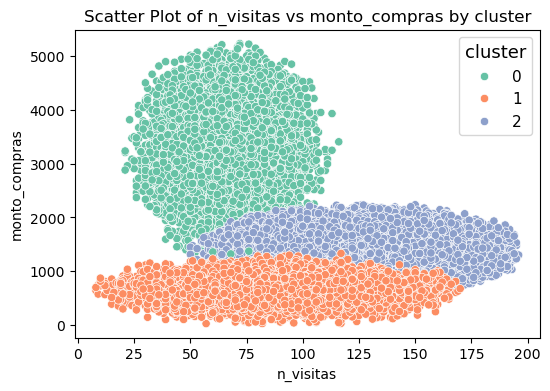

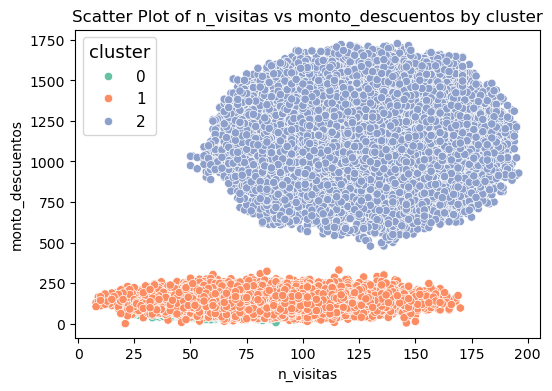

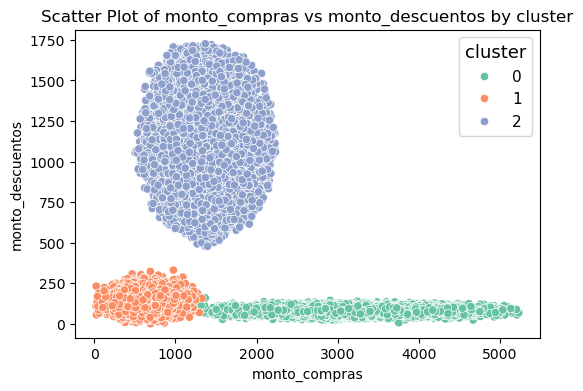

In [158]:
def plot_pairwise_scatter(df, cluster_column, variable_1, variable_2):
    """
    Plot a pairwise scatter plot for the two specified variables within each cluster.
    
    Parameters:
    - df: The dataframe containing the clusters and variables.
    - cluster_column: The name of the column that indicates the cluster.
    - variable_1: The name of the first variable to plot.
    - variable_2: The name of the second variable to plot.
    """
    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=df, x=variable_1, y=variable_2, hue=cluster_column, palette='Set2')
    plt.title(f'Scatter Plot of {variable_1} vs {variable_2} by {cluster_column}')
    plt.xlabel(variable_1)
    plt.ylabel(variable_2)
    plt.legend(title=cluster_column, title_fontsize='13', fontsize='11')
    plt.show()

plot_pairwise_scatter(df, 'cluster', 'n_visitas', 'monto_compras')
plot_pairwise_scatter(df, 'cluster', 'n_visitas', 'monto_descuentos')
plot_pairwise_scatter(df, 'cluster', 'monto_compras', 'monto_descuentos')

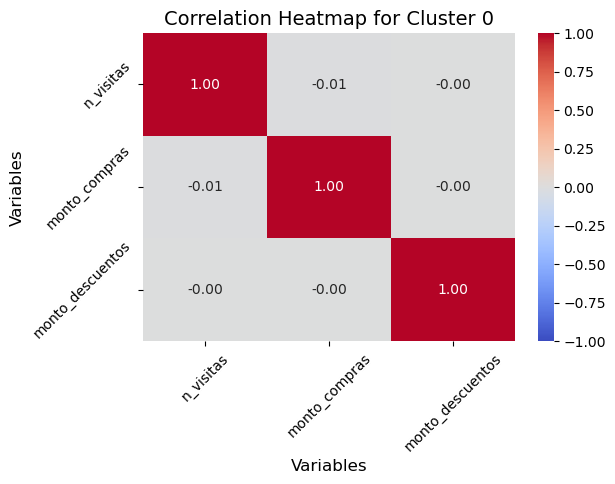

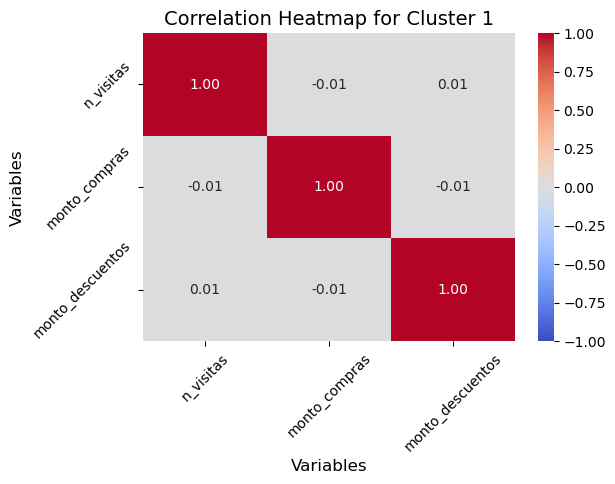

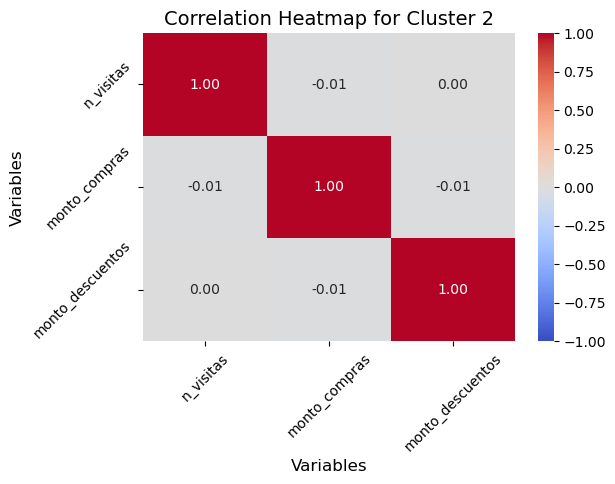

In [160]:
def plot_correlation_heatmap_by_cluster(df, cluster_column='cluster'):
    """
    Creates a correlation heatmap for each cluster.

    Parameters:
        df (pd.DataFrame): The dataframe containing the data.
        cluster_column (str): The column representing the clusters (default: 'cluster').

    Returns:
        None: Displays the correlation heatmaps.
    """
    clusters = df[cluster_column].unique()
    for cluster in clusters:
        cluster_data = df[df[cluster_column] == cluster].drop(columns=["cluster"])
        corr_matrix = cluster_data.corr()
        plt.figure(figsize=(6, 4))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True, vmin=-1, vmax=1)
        plt.title(f'Correlation Heatmap for Cluster {cluster}', fontsize=14)
        plt.xlabel('Variables', fontsize=12)
        plt.ylabel('Variables', fontsize=12)
        plt.xticks(fontsize=10, rotation=45)
        plt.yticks(fontsize=10, rotation=45)
        plt.show()

plot_correlation_heatmap_by_cluster(df)

#### Cluster Analysis Summary

In this analysis, we explored the behavior and characteristics of three customer clusters based on three key variables: **n_visitas** (number of visits), **monto_compras** (purchase amount), and **monto_descuentos** (discount amount). Below are the key insights and findings:

##### Key Insights:

1. **Cluster 0**:  
   - **Characteristics**: High **monto_compras**, but low **n_visitas** and minimal **monto_descuentos**.
   - **Interpretation**: These are likely high-value customers who make large purchases but do not visit frequently or use many discounts. They might be loyal customers who do not need additional incentives.
   
2. **Cluster 1**:  
   - **Characteristics**: Low **monto_compras**, moderate **n_visitas**, and moderate **monto_descuentos**.
   - **Interpretation**: This cluster seems to represent potential or newer customers who make fewer purchases but visit more often and use discounts to encourage purchases. This group may benefit from retention strategies.

3. **Cluster 2**:  
   - **Characteristics**: Moderate **monto_compras**, high **n_visitas**, and high **monto_descuentos**.
   - **Interpretation**: These customers appear to be highly engaged and driven by discounts. They are likely to respond well to promotional offers, making them a key target for discount-based marketing campaigns.

##### Findings:
- There is **no significant correlation** between the variables within any of the clusters, suggesting that the clusters are differentiated primarily by behavior rather than by direct relationships between variables.
- The **PCA analysis** further confirmed the distinct patterns of customer behavior in each cluster, particularly in their use of discounts and purchase amounts.

##### Implications for Strategy:
- **Cluster 0**: Focus on **retention** and offering exclusive services or experiences, as these customers already spend high amounts without needing heavy discounts.
- **Cluster 1**: Focus on **fostering loyalty** through discounts, personalized offers, or re-engagement strategies to increase their purchase frequency.
- **Cluster 2**: Target with **aggressive promotional campaigns**, as these customers are highly responsive to discounts and promotions.

By understanding the unique behaviors of each cluster, businesses can tailor their marketing and sales strategies to better meet the needs of each group, leading to improved customer satisfaction and higher sales.